In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from altaipony.ffd import FFD

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 13

In [37]:
df = pd.read_csv("../k2scoc/results/tables/full_table.csv")
df.head(30)

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dtp_tot,...,real,length,note,cluster,Lum_Kepler,e_Lum_Kepler,Teff_median,Teff_std,todrop,double_peak
0,2005.0,2030.0,105828.0,105854.0,2271.380070,2271.911291,390.877871,4.193384,0.016548,3282,...,0.0,25.0,NaN,hyades,3.562501e+30,9.535661e+29,3511.307394,75.080192,NaN,0.0
1,1907.0,1935.0,105729.0,105758.0,2269.357343,2269.949859,284.387645,4.848855,0.009683,3282,...,0.0,28.0,NaN,hyades,3.562501e+30,9.535661e+29,3511.307394,75.080192,NaN,0.0
2,1870.0,1876.0,105691.0,105698.0,2268.580942,2268.723963,73.404611,7.026491,0.006631,3282,...,0.0,6.0,NaN,hyades,3.562501e+30,9.535661e+29,3511.307394,75.080192,NaN,0.0
3,1831.0,1841.0,105651.0,105662.0,2267.763678,2267.988426,96.207856,6.176100,0.006221,3282,...,0.0,10.0,NaN,hyades,3.562501e+30,9.535661e+29,3511.307394,75.080192,NaN,0.0
4,1171.0,1174.0,104966.0,104969.0,2253.767988,2253.829284,27.441864,3.044179,0.005928,3282,...,1.0,3.0,NaN,hyades,3.562501e+30,9.535661e+29,3511.307394,75.080192,NaN,0.0
5,1073.0,1078.0,104863.0,104868.0,2251.663517,2251.765676,105.114557,2.035246,0.030904,3282,...,1.0,5.0,NaN,hyades,3.562501e+30,9.535661e+29,3511.307394,75.080192,NaN,0.0
6,988.0,991.0,104774.0,104777.0,2249.845088,2249.906383,25.163159,1.618849,0.006088,3282,...,1.0,3.0,NaN,hyades,3.562501e+30,9.535661e+29,3511.307394,75.080192,NaN,0.0
7,1775.0,1780.0,105594.0,105599.0,2266.599077,2266.701235,23.008047,2.932911,0.003165,3282,...,0.0,5.0,NaN,hyades,3.562501e+30,9.535661e+29,3511.307394,75.080192,NaN,0.0
8,164.0,167.0,103915.0,103918.0,2232.294133,2232.355429,205.179048,8.061198,0.065238,3282,...,1.0,3.0,NaN,hyades,5.300078e+29,1.556703e+29,3146.319787,56.106124,NaN,0.0
9,253.0,256.0,104008.0,104011.0,2234.194522,2234.255819,260.684544,7.395745,0.076040,3282,...,1.0,3.0,NaN,hyades,1.455241e+29,4.433167e+28,2936.877398,75.574934,NaN,0.0


In [40]:
df["LC_time_years"] = df.dtp_tot / 2. / 24. / 365.25
tobs = df[["LC_time_years","EPIC","C"]].drop_duplicates().LC_time_years.sum()

In [41]:
df = df[(df.real != -1) & (df.real != 0) & (df.note.isnull())]
df.shape

(3509, 23)

## Full sample FFD


Setting ED with new values, size 2545.
Setting frequency values with new values, size 2545.
Setting frequency adjusted count values with new values, size 2545.
Setting multiple_stars flag with True.
Setting ED with new values, size 2545.
Setting frequency values with new values, size 2545.
Setting frequency adjusted count values with new values, size 11153.
Setting frequency adjusted count values with new values, size 992.
Setting ED with new values, size 992.
Setting frequency values with new values, size 992.
Fitted power law beta=980.7023204680412


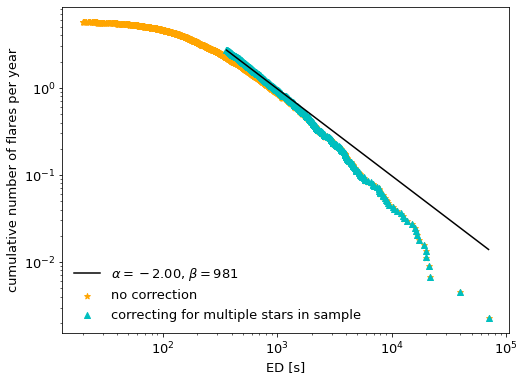

In [42]:
fig, ax =  plt.subplots(1, figsize=(8,6))
ffd = FFD(f=df[df.ed_rec > 20.], tot_obs_time=tobs, ID="EPIC")

#---------- No correction ----------------
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="orange", marker="*", label="no correction")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min()

ffd.count_ed = ffd.count_ed[np.where(ffd.count_ed>thresh)]
ffd.ed = ed[np.where(ed>thresh)]
ffd.freq = freq[np.where(ed>thresh)]

# alpha, alpha_err = ffd.fit_powerlaw()
# print(f"Fitted power law alpha={ffd.alpha}")

ffd.alpha, ffd.alpha_err = 2., .2

betas, beta, beta_err = ffd.fit_beta_to_powerlaw()
print(f"Fitted power law beta={ffd.beta}")

ispowerlaw = ffd.is_powerlaw()
truncated = ffd.is_powerlaw_truncated()


ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")
a, x, y = ffd.plot_powerlaw(ax, c="k", label=fr"$\alpha=-${ffd.alpha:.2f}, $\beta=${int(np.rint(ffd.beta))}")

plt.xscale("log")
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("ED [s]")
plt.ylabel("cumulative number of flares per year")

plt.savefig(f"plots/{tstamp}_full_sample_ffd.png", dpi=300)

In [43]:
ispowerlaw, truncated

(False, True)

## Teff bins


In [161]:
cepic = df[["LC_time_years","EPIC","C", "Teff_median", "cluster"]].drop_duplicates()
bins_T = pd.cut(cepic["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"])
T = cepic.groupby([bins_T, "cluster"]).LC_time_years.sum().reset_index()
T

,Teff_median,cluster,LC_time_years
0,2500-3000,hyades,3.201118
1,2500-3000,ngc2682,NaN
2,2500-3000,ngc6774,NaN
3,2500-3000,pleiades,9.734428
4,2500-3000,praesepe,2.125998
5,3000-3250,hyades,10.870694
6,3000-3250,ngc2682,NaN
7,3000-3250,ngc6774,NaN
8,3000-3250,pleiades,59.529774
9,3000-3250,praesepe,57.661305


2500-3000 hyades
(41, 22)
Setting ED with new values, size 29.
Setting frequency values with new values, size 29.
Setting frequency adjusted count values with new values, size 29.
Setting multiple_stars flag with True.
Setting ED with new values, size 29.
Setting frequency values with new values, size 29.
Setting frequency adjusted count values with new values, size 84.
2500-3000 pleiades
(59, 22)
Setting ED with new values, size 55.
Setting frequency values with new values, size 55.
Setting frequency adjusted count values with new values, size 55.
Setting multiple_stars flag with True.
Setting ED with new values, size 55.
Setting frequency values with new values, size 55.
Setting frequency adjusted count values with new values, size 241.
2500-3000 praesepe
(17, 22)
Setting ED with new values, size 13.
Setting frequency values with new values, size 13.
Setting frequency adjusted count values with new values, size 13.
Setting multiple_stars flag with True.
Setting ED with new values, si

Setting multiple_stars flag with True.
Setting ED with new values, size 61.
Setting frequency values with new values, size 61.
Setting frequency adjusted count values with new values, size 338.
5000-6000 hyades
(30, 22)
Setting ED with new values, size 4.
Setting frequency values with new values, size 4.
Setting frequency adjusted count values with new values, size 4.
Setting multiple_stars flag with True.
Setting ED with new values, size 4.
Setting frequency values with new values, size 4.
Setting frequency adjusted count values with new values, size 8.
5000-6000 ngc2682
(259, 22)
Setting ED with new values, size 70.
Setting frequency values with new values, size 70.
Setting frequency adjusted count values with new values, size 70.
Setting multiple_stars flag with True.
Setting ED with new values, size 70.
Setting frequency values with new values, size 70.
Setting frequency adjusted count values with new values, size 336.
5000-6000 ngc6774
(120, 22)
Setting ED with new values, size 26

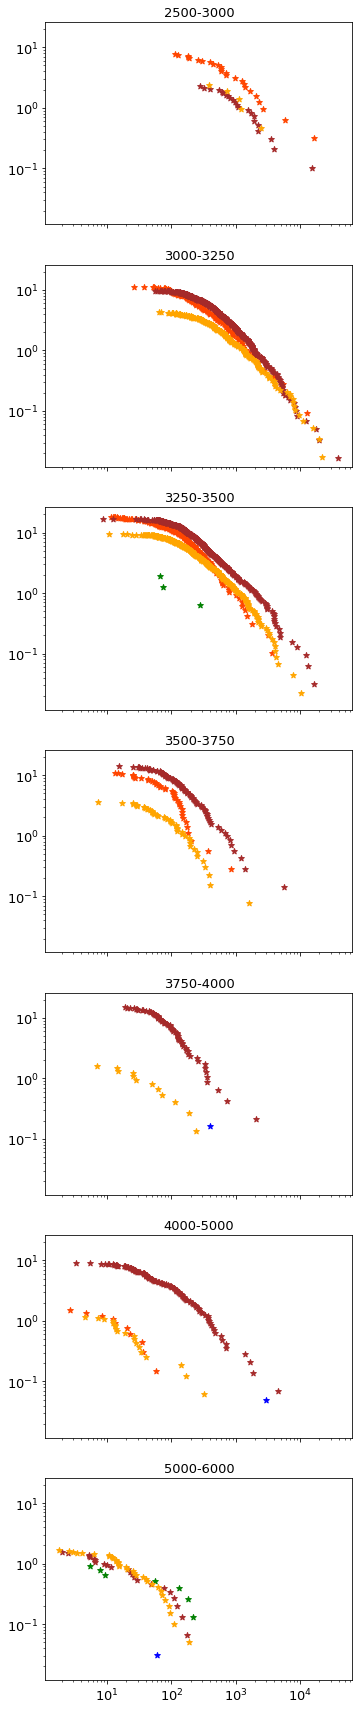

In [162]:
labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"]
bins_T = pd.cut(df["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=labels)
ccol = dict(zip(['pleiades',"hyades","praesepe","ngc6774","ngc2682"],
                ["brown","orangered","orange","green","blue"]))
fig, axes = plt.subplots(nrows=7,ncols=1,figsize=(5.5,30.5), sharex=True, sharey=True, squeeze=True)
k = 0
for i, g in df.groupby(bins_T):
    for j, h in g.groupby("cluster"):
        print(i,j)
        print(h.shape)
        tobs = T[(T.Teff_median == i) & (T.cluster == j)].LC_time_years.values[0]
        h = h[(h.real != -1) & (h.real != 0) & (h.note.isnull())]
        if h.shape[0] == 0:
            continue
        else:
            ffd = FFD(f=h, tot_obs_time=tobs, ID="EPIC")

            #---------- No correction ----------------
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=False)
            axes[k].scatter(ed, freq, c=ccol[j], marker="*", label="no correction")


            #---------- multiple stars 
            ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                                        recovery_probability_correction=False,
                                         multiple_stars=True)
            #axes[k].scatter(ffd.ed, ffd.freq, marker="^", c=ccol[j], label="correcting for multiple stars in sample")

            axes[k].set_xscale('log')
            axes[k].set_yscale('log')
            #axes[k].set_ylim(.04, 1e3)
            #axes[k].set_xlim(4, 1e4)
            axes[k].set_title(i)
            #axes[k].legend()
    k += 1

In [169]:
df2 = df[(df.real != -1) & (df.real != 0) & (df.note.isnull())]
df2[(df2.cluster=="ngc6774") & (df2.Teff_median > 5000.)].dropna(subset=["real"])[["EPIC","Teff_median", "ed_rec"]]

,EPIC,Teff_median,ed_rec
3650,219341906,5638.810000,5.427365
3651,219341906,5638.810000,9.412684
3717,219601739,5458.330000,7.775393
3720,219610232,5226.132958,130.007534
3721,219610232,5226.132958,55.940481
3722,219610232,5226.132958,181.678799
3723,219610232,5226.132958,215.735288


## Rup 147

- 219426848 spectroscopic binary with double line (Curtis 2013)
- **219591752** unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+14+11.962+%09-16+21+38.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=) the cool star! 3315 K
- **219341906** - nothing special from Curtis 2013
- **219601739** - nothing special from Curtis 2013, 
- **219610232** - unremarkable Gaia target [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=19+13+31.091+%09-16+18+40.14+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), Cantat-Gaudin+ 2018: 100% member

## M67

- 211406144 -  RG 
- 211409376 -  RS CVn
- **211434440** - ? 5000-6000 (no obvious info on [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+48+55.901+%09%2B12+09+42.93+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=))
   - Huber+ 2016: 
   ```
                   lo     [F                                                                                  
          Tef   logg ([c Fe/H] ( Rad     Mass                       E(B-V   F   RA          DE                
    EPIC      f (K) m/s2]) [Sun]) (Rsun)  (Msun) rho (Sun) Dist (pc) ) (mag) lag J2000 (deg) J2000 (deg) A15 2M
    --------- ----- ------ ------ ------- ------ --------- --------- ------- --- ----------- ----------- --- --
    211434440  5236  4.545 -0.210   0.823  0.870  1.53e+00  6.20e+02  0.0338 rpm 132.2329270 +12.1619250   0 2M
   ```
  If the flare is real: 6.3e+33 erg energy released! 
- 211412587 - ? 5000-6000 spectroscopic binary [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+51+23.778+%09%2B11+49+49.38+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=)
- 211417284 - ? 5000-6000 cataclysmic variable star [simbad](http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=08+50+36.996+%09%2B11+54+04.67+%09&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcsec&submit=submit+query&CoordList=), (0.64 day period, star 01610 in Nardiello+ 2016), [Mooley and Singh 2015](https://academic.oup.com/mnras/article/452/4/3394/1055661) :
     ```
     _Belloni et al. (1998)useB−V=0.38 from Sanders (1977) and hardness of the X-rayspectrum to claim that this could be an accreting white dwarf system. Orbital parameters areunknown. However, EIS hasB−V=0.79, and our hardness ratios are HR1=0.66±0.20,HR2=−0.48±0.30. The position in the HR diagram and absence of soft and hard X-raycomponents therefore argue against the CV hypothesis for this source_
     ```
- 200233344 - ? 4000-5000 resolved to EPIC 211414300 2MASS J08514235+1151230 RGB star
- 200233429 - ? 5000-6000  	2MASS J08504609+1143082 spectroscopic binary
- **211390071** - 12.6 period rotationally var. 4000-5000
 If the flare is real 5.9e34 erg
- **211396661** - 21.23 period rotationally var 3750-4000, "no clear variation" (Gonzalez 2016)
 If the flare is real 4.6e34 erg
- 211409644 - spectrocscopic binary

The poster flare was in the Nardiello sample.

In [152]:
df2 = df[(df.real != -1) & (df.real != 0) & (df.note.isnull())]
df2[(df2.cluster=="ngc2682") & (df2.Teff_median < 6000.)].dropna(subset=["real"]).EPIC

2762    211434440
4802    211390071
4824    211396661
Name: EPIC, dtype: int64